# Parametric Statistics and Bayesian Parameter Estimation
### Course: Astroinformatics
### Profs: Valentino Gonzalez; Francisco Forster
### Author: Jose Vines
### Mail: jose.vines@ug.uchile.cl

In this demo we are going to review parametric statistics combined with bayesian statistics.

First let's recall the Bayes' Theorem, given observed data $X$ and a parameter vector $\hat{\theta}$ corresponding to model $M$

$$P\left(\hat{\theta} | X, M\right) = \frac{P\left(X|\hat{\theta}, M\right)P\left(\hat{\theta}|M\right)}{P(X|M)}$$

Where $P\left(X|\hat{\theta}, M\right)$ is the likelihood function and $P\left(\hat{\theta}|M\right)$ is the prior function. The denominator, $P(X|M)$, is called the marginalized distribution of the dataset over all parameter values in model $M$, also called marginal likelihood or model evidence. This number is essential for a number of applications, but can be very hard to compute, luckily we can disregard it as a normalization factor. On the left side we find $P\left(\hat{\theta} | X, M\right)$, the posterior distribution, which is what we are interested in.

## Why do bayesian estimations when a $\chi^2$ minimization or similar approaches are so much faster?

The most important reasons to use bayesian statistics are two-fold:
1. With bayesian statistics we can incorporate prior beliefs into the modeling.
2. Bayesian estimates provide a posterior **distribution** from which we can compute a number of statistics, whereas a simple $\chi^2$ approach usually provides a number.

We'll use PyMC3 for this demonstration, you can install with via pypi with `pip install pymc3` or with conda through `conda install -c conda-forge pymc3`

In [1]:
import pymc3 as pm
print(f'Running PyMC3 v{pm.__version__}')

Running PyMC3 v3.9.3


We're going to estimate the $\rho$ parameter from the binomial distribution given some data

Remember the binomial distribution's probability mass function
$$
P\left(X = k\right) = {n\choose k} \rho^k(1-\rho)^{n-k}
$$
Where $${n \choose k} = \frac{n!}{k!(n-k)!}$$ is the usual combination formula, n is the number of experiments and k is the number of 'succeses'.

Take the study by Tokovinin 2014 where he studied a sample of 4847 stars in a sample from the Hipparcos catalog, he found that 2196 of these stars were in multiple systems (i.e. systems with more than 1 star). We are interested in knowing the distribution of the stellar multiplicity factor, ideally we would observe a larger number of stars and study them in detail to see if they have stellar companions or not, but this is too expensive, so we resort to simulations. We carry out 150 simulations of 500 stellar systems and saved our results in a file called Simulations.dat

First let's do some basic imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az  # We'll use this to visualize PyMC3 things!

[ArviZ](https://arviz-devs.github.io/arviz/) is a tool for exploratory analysis of Bayesian models, so we'll make use of it here to aid in visualization

In [3]:
az.style.use('arviz-darkgrid')
%matplotlib inline

In [4]:
sims = np.loadtxt('assets/Simulations.dat')

sims corresponds to the number of multiple stellar systems out of 500 simulated systems for 150 simulations and it looks like this:

In [5]:
sims

array([237., 225., 242., 222., 239., 240., 237., 233., 234., 230., 215.,
       248., 222., 230., 232., 234., 241., 249., 234., 231., 247., 229.,
       237., 234., 212., 228., 235., 227., 213., 221., 249., 238., 211.,
       236., 227., 232., 218., 205., 235., 221., 231., 242., 227., 206.,
       252., 236., 218., 220., 237., 218., 213., 213., 244., 229., 250.,
       239., 243., 223., 230., 245., 225., 222., 227., 227., 224., 213.,
       236., 251., 239., 240., 233., 237., 226., 235., 247., 237., 232.,
       240., 233., 227., 233., 211., 242., 256., 224., 221., 226., 216.,
       225., 210., 242., 226., 240., 240., 219., 242., 224., 248., 244.,
       233., 223., 237., 243., 256., 227., 232., 236., 221., 227., 233.,
       234., 244., 233., 246., 250., 248., 242., 231., 228., 221., 222.,
       223., 215., 206., 213., 215., 223., 230., 252., 225., 215., 236.,
       226., 221., 230., 232., 236., 228., 235., 234., 234., 240., 233.,
       241., 239., 233., 217., 245., 245., 250.])

Now that we have our data and problem defined we need to build our model, with PyMC3 defining a model is fairly straightforward.

The first step is coming up with a prior distribution, but we have no information other that $\rho\,\in\,[0, 1]$, thus we'll use a uniform prior. $$\rho \sim U\left(0, 1\right)$$ Naturally, our log likelihood will be the binomial distribution $$Y\sim B\left(N, \rho\right)$$ where $N$ is the number of experiments, in this case, the number of simulations.
While the log likelihood is easy to calculate analiticaly, PyMC3 already comes with a handful of continuous and discrete distributions. [You can check the API for information on the implemented distributions.](https://docs.pymc.io/api/distributions.html)

Now we just have to write up our model. With PyMC3 this is done like this

In [6]:
model = pm.Model()
with model:
    # First we set up the prior
    rho = pm.Uniform('rho', 0.001, .999)
    # And now we'll set up the log likelihood. Remember we did 150 simulations
    Y = pm.Binomial('Y', n=500, p=rho, observed=sims)

Let's explain what's happening here.

The line `model = pm.Model():` creates a new Model object which is a container for the model's random variables and the next line creates a context manager with the `with` statement that sets the model as the context. This means all PyMC3 objects introduced within the block below the `with` statement are added to the model automatically for us!

The line `rho = pm.Uniform('rho', 0, 1)` creates a **stochastic** random variable with a Uniform prior distribution with a lower and upper boundary of 0 and 1 respectively. The first argument (for any distribution class) is **always** the name of the random variable (which _should_ match the name of the variable assigned to it), the remaining arguments are the boundaries for the Uniform distribution. Remember to [check the API documentation](https://docs.pymc.io/api/distributions.html) for specific information of your distributions.

The final line `Y = pm.Binomial('Y', 150, rho)` defines the sampling distribution of the outcomes in the dataset!

Now that we defined our model, we need to get posterior estimates for the unknown variable, $\rho$. There are a couple of ways to do this, one would be the **maximum a posteriori (MAP)** estimate which gives a parameter point, but we're not interested in knowing a single point, we're looking for a whole distribution for $\rho$. The best approach for the latter is using **Markov Chain Monte Carlo (MCMC)** methods, so we'll do just that!

To do MCMC in PyMC3 we need to define a **step method** object, which corresponds to a specific MCMC algorithm (for example, the Metropolis algorithm). PyMC3's _step\_methods_ submodule contains the following samples: No-U-Turn Sampler (NUTS), Metropolis, Slice, HamiltonianMC, and BinaryMetropolis. You can assign the step methods manually, but PyMC3 has an auto-assignment algorithm based on the attributes of each variable in the model, these are
- Binary vairables -> BinaryMetropolis
- Discrete variables -> Metropolis
- Continuous variables -> NUTS

Now we'll sample the posterior space

In [7]:
with model:
    # Draw 10000 posterior samples
    trace = pm.sample(10000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 24 seconds.


trace now holds information about our recent fit. For now we're just interested in the samples of our parameters which we can easily acces as a dictionary

We'll now visualize what just happened using [ArviZ](https://arviz-devs.github.io/arviz/), in particular, we'll show the posterior distribution for $\rho$ for each chain along with the trace plot (i.e. the individual steps of each walker)

/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


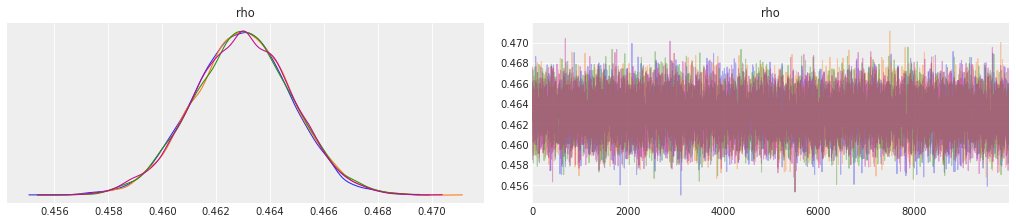

In [8]:
az.plot_trace(trace, figsize=(14, 3));

We can see $\rho$ is nicely distributed and has a single maxima, we can also see that all of the chains have restricted their movements enough for us to calculate things like the best value for $\rho$ or a confidence interval. Let's calculate the mean, median, 1, 2 and 3 sigma confidence intervals for $\rho$!

In [9]:
med = np.median(trace['rho'])  # First the median
mean = trace['rho'].mean()  # Now the mean

For the credibility interval we'll use a function written by myself called, credibility_interval

In [10]:
from scipy.special import erf

def credibility_interval(post, alpha=1.):
    """Calculate bayesian credibility interval.
    Parameters:
    -----------
    post : array_like
        The posterior sample over which to calculate the bayesian credibility
        interval.
    alpha : float, optional
        Confidence level.
    Returns:
    --------
    med : float
        Median of the posterior.
    low : float
        Lower part of the credibility interval.
    up : float
        Upper part of the credibility interval.
    """
    z = erf(alpha / np.sqrt(2))

    lower_percentile = 100 * (1 - z) / 2
    upper_percentile = 100 * (1 + z) / 2
    low, med, up = np.percentile(
        post, [lower_percentile, 50, upper_percentile]
    )
    return med, low, up

In [11]:
_, low1, up1 = credibility_interval(trace['rho'], alpha=1)
_, low2, up2 = credibility_interval(trace['rho'], alpha=2)
_, low3, up3 = credibility_interval(trace['rho'], alpha=3)

And now we'll print everything

In [12]:
output = f'Rho summary:\nmean : {mean:.3f}\nmedian : {med:.3f}\n1 sigma CI : [{low1:.3f}, {up1:.3f}]\n'
output += f'2 sigma CI : [{low2:.3f}, {up2:.3f}]\n3 sigma CI : [{low3:.3f}, {up3:.3f}]'
print(output)

Rho summary:
mean : 0.463
median : 0.463
1 sigma CI : [0.461, 0.465]
2 sigma CI : [0.459, 0.467]
3 sigma CI : [0.457, 0.469]


While this was a simplified example on parametrical statistics and bayesian inference, the context of the example is quite real. While more complex, Tokovinin did simulate stellar systems to find out if the simulations supported the Hipparcos observations that ~45% of stars are found in multiple systems. He got a value of 45.5% which he later approximated to 46%